# IMPORT MODULES

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from sklearn.pipeline import Pipeline

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

bc = pd.read_csv('seatle_after_feature_engineering.csv')

# SiteEnergyUse

DummyRegressor R² : -0.20413757530890475
DummyRegressor MAPE : 129.24195950409282
DummyRegressor RMSE : 4976891129433.967
LinearRegression Coeff: [ 1.73171268e+05  1.16561677e+06  5.34874393e+05  1.21614567e+05
  1.71499064e+05 -8.61489623e+04  1.06144192e+06 -9.72807826e+03
  6.09308469e+04  8.47156059e+04 -1.07255837e+03 -2.37302960e+03
 -2.74397995e+04 -4.66104554e+04 -5.20070303e+04 -2.09074136e+04
  4.55786149e+04 -3.81063410e+04 -7.69207233e+04  5.01371367e+04
  6.15159271e+04 -3.47463058e+04 -4.38004973e+04 -1.27606296e+04
  3.44806380e+04  1.05657638e+03  1.79097230e+04  8.34006883e+03
 -1.03341302e+04  4.60599853e+03  8.29662737e+04 -4.77566360e+04
  8.81313059e+03 -1.66460301e+04  2.91852910e+04  1.64788833e+04]
LinearRegression R²: 84.23235878143016
LinearRegression MAPE: 31.88162414390187
LinearRegression RMSE: 783139654825.3335
SVR R² : -14.177629547633108
SVR MAPE : 90.00762510331943
SVR RMSE : 5670919838498.106


/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: i

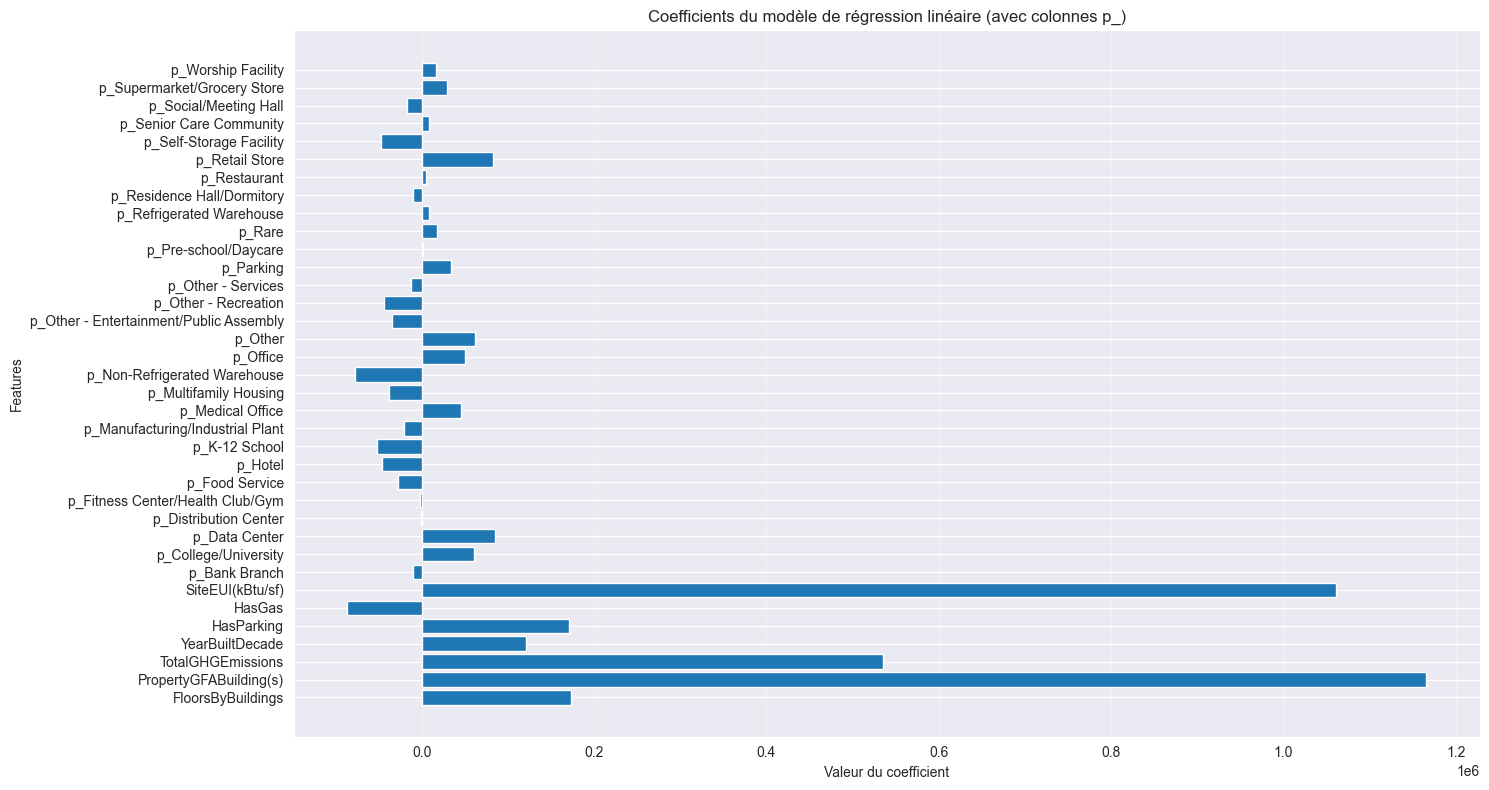

In [10]:
# Calcul de la consommation d'electricite au m2
bc['ElectricityByGFA'] = bc['Electricity(kBtu)'] / bc['PropertyGFABuilding(s)']
#print(bc['ElectricityByGFA'])

# Calcul du nombre d'étages par batiment
bc['FloorsByBuildings'] = (bc['NumberofBuildings'] * bc['NumberofFloors'])
#print(bc['FloorsByBuildings'])

base_columns = ['FloorsByBuildings', 'PropertyGFABuilding(s)',  'TotalGHGEmissions', 'YearBuiltDecade', 'HasParking', 'HasGas', 'SiteEUI(kBtu/sf)']
p_columns = [col for col in bc.columns if col.startswith('p_')]
all_columns = base_columns + p_columns
X = bc[all_columns]

y = bc['SiteEnergyUse(kBtu)']

#######################################
#######################################
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=666)
# Baseline Dummy Regressor
dummy = DummyRegressor(strategy="mean")  # ou "median"
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

# Évaluation
print("DummyRegressor R² :", r2_score(y_test, y_pred)*100)
print("DummyRegressor MAPE :", mean_absolute_percentage_error(y_test, y_pred)*100)
print("DummyRegressor RMSE :", mean_squared_error(y_test, y_pred))

#######################################
#######################################

scaler = StandardScaler()
X_Scaler = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split( X_Scaler, y, train_size=0.8, random_state=666)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"LinearRegression Coeff: {model.coef_}")

print(f"LinearRegression R²: {r2_score(y_test, y_pred_test)*100}")
print(f"LinearRegression MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)*100}")
print(f"LinearRegression RMSE: {mean_squared_error(y_test, y_pred_test)}")

#######################################
#######################################

# Pipeline avec scaling (indispensable pour SVR)
svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10, epsilon=0.1, gamma="scale"))
])

# Entraînement
svr.fit(X_train, y_train)

# Prédiction
y_pred = svr.predict(X_test)

# Évaluation
print("SVR R² :", r2_score(y_test, y_pred)*100)
print("SVR MAPE :", mean_absolute_percentage_error(y_test, y_pred)*100)
print("SVR RMSE :", mean_squared_error(y_test, y_pred))

#######################################
#######################################

plt.figure(figsize=(15, 8))  # Plus large pour accommoder plus de features

# Graphique horizontal pour mieux lire les noms de colonnes
plt.barh(list(X.columns), model.coef_)
plt.title('Coefficients du modèle de régression linéaire (avec colonnes p_)')
plt.xlabel('Valeur du coefficient')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#########  validation croisée #########

######### StandardScaler #########

######### Inférence #########

######### Evaluation #########
# R² : proportion de variance expliquée.
# MAE (Mean Absolute Error) : erreur absolue moyenne.
# RMSE (Root Mean Squared Error) : pénalise plus fortement les grosses erreurs.

######### Interprétation #########
#Comparer les métriques train/test pour juger du sur-apprentissage.
#Déterminer le modèle le plus performant et le plus robuste.


# TotalGHGEmissions

DummyRegressor R² : -0.7216366331317836
DummyRegressor MAPE : 240.6176180394804
DummyRegressor RMSE : 2585.589862442421
LinearRegression Coeff: [ 1.37179391e+00  3.26947380e+00 -3.82318295e+00 -3.81485852e+00
  1.32838569e+01  2.75764507e+01  1.29600903e+01  2.09371844e-01
 -5.85854634e-01 -1.07660391e+00  9.05990035e-01  1.98441075e+00
  1.96003089e+00  6.34420340e+00  5.85876772e+00 -1.03432039e+00
 -1.90889280e+00  1.07997312e+00  2.18760496e+00 -2.68735495e+00
 -1.48841846e+00 -5.83100215e-02  1.55954730e+00 -1.11634996e-01
 -1.44062860e+00 -1.66929635e+00  1.40800656e+00 -9.75372036e-01
  2.92619728e+00 -5.68263514e-01 -1.52147263e+00  8.46042377e-01
  3.25849992e+00  2.67794773e-02 -2.63103623e+00  1.97274725e+00]
LinearRegression R²: 68.28615944151689
LinearRegression MAPE: 82.91783615899891
LinearRegression RMSE: 814.1148951520921
SVR R² : 45.087797724376
SVR MAPE : 68.45440434689618
SVR RMSE : 1409.6319149915146


/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: i

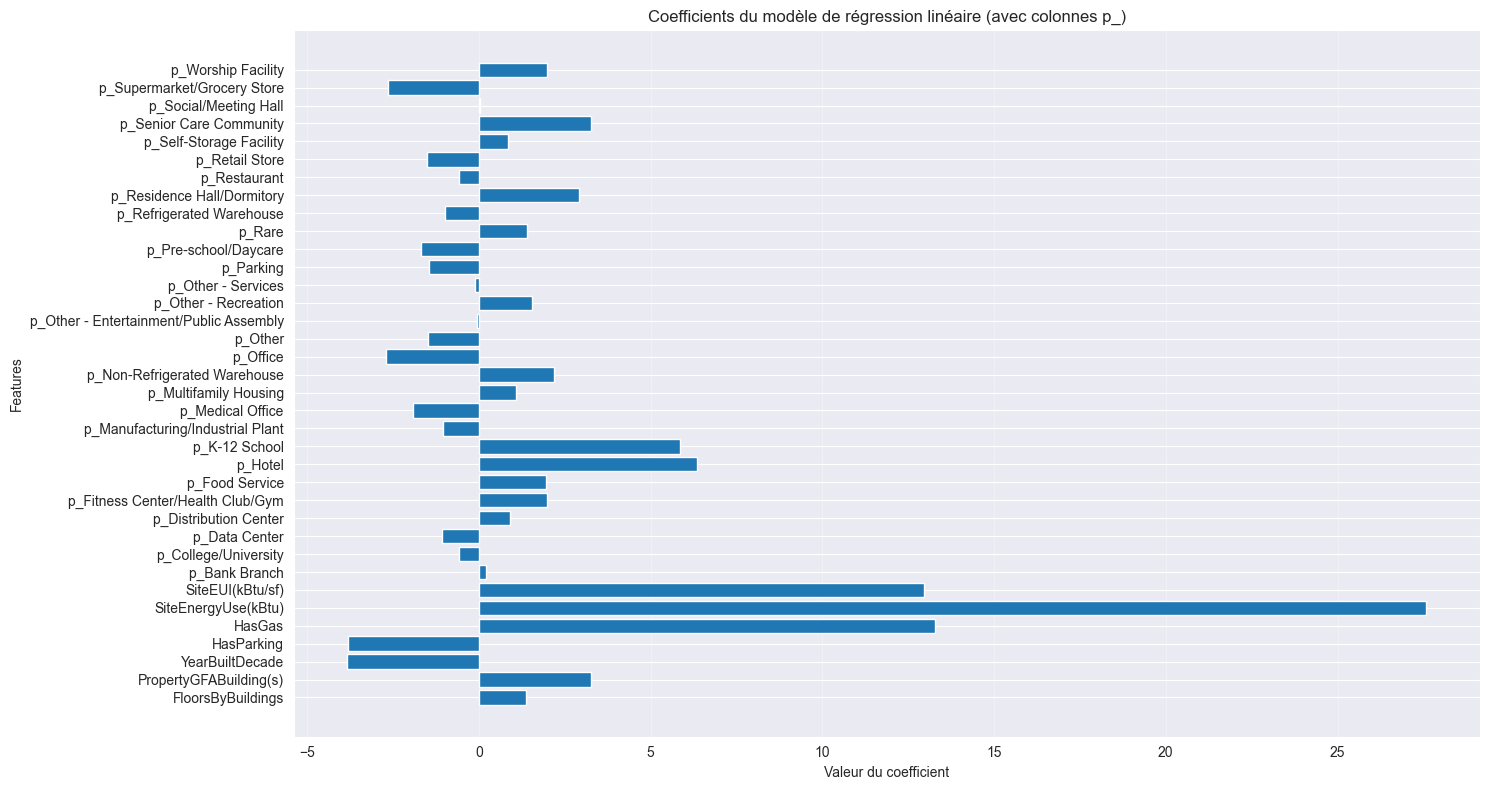

In [11]:
# Calcul de la consommation d'electricite au m2
bc['ElectricityByGFA'] = bc['Electricity(kBtu)'] / bc['PropertyGFABuilding(s)']
#print(bc['ElectricityByGFA'])

# Calcul du nombre d'étages par batiment
bc['FloorsByBuildings'] = (bc['NumberofBuildings'] * bc['NumberofFloors'])
#print(bc['FloorsByBuildings'])

base_columns = ['FloorsByBuildings', 'PropertyGFABuilding(s)', 'YearBuiltDecade', 'HasParking', 'HasGas', 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)']
p_columns = [col for col in bc.columns if col.startswith('p_')]
all_columns = base_columns + p_columns
X = bc[all_columns]

y = bc['TotalGHGEmissions']

#######################################
#######################################
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=666)
# Baseline Dummy Regressor
dummy = DummyRegressor(strategy="mean")  # ou "median"
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

# Évaluation
print("DummyRegressor R² :", r2_score(y_test, y_pred)*100)
print("DummyRegressor MAPE :", mean_absolute_percentage_error(y_test, y_pred)*100)
print("DummyRegressor RMSE :", mean_squared_error(y_test, y_pred))

#######################################
#######################################

scaler = StandardScaler()
X_Scaler = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split( X_Scaler, y, train_size=0.8, random_state=666)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"LinearRegression Coeff: {model.coef_}")

print(f"LinearRegression R²: {r2_score(y_test, y_pred_test)*100}")
print(f"LinearRegression MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)*100}")
print(f"LinearRegression RMSE: {mean_squared_error(y_test, y_pred_test)}")

#######################################
#######################################

# Pipeline avec scaling (indispensable pour SVR)
svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10, epsilon=0.1, gamma="scale"))
])

# Entraînement
svr.fit(X_train, y_train)

# Prédiction
y_pred = svr.predict(X_test)

# Évaluation
print("SVR R² :", r2_score(y_test, y_pred)*100)
print("SVR MAPE :", mean_absolute_percentage_error(y_test, y_pred)*100)
print("SVR RMSE :", mean_squared_error(y_test, y_pred))

#######################################
#######################################

plt.figure(figsize=(15, 8))  # Plus large pour accommoder plus de features

# Graphique horizontal pour mieux lire les noms de colonnes
plt.barh(list(X.columns), model.coef_)
plt.title('Coefficients du modèle de régression linéaire (avec colonnes p_)')
plt.xlabel('Valeur du coefficient')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#########  validation croisée #########

######### StandardScaler #########

######### Inférence #########

######### Evaluation #########
# R² : proportion de variance expliquée.
# MAE (Mean Absolute Error) : erreur absolue moyenne.
# RMSE (Root Mean Squared Error) : pénalise plus fortement les grosses erreurs.

######### Interprétation #########
#Comparer les métriques train/test pour juger du sur-apprentissage.
#Déterminer le modèle le plus performant et le plus robuste.
